<a href="https://colab.research.google.com/github/Shuqi-Lin/Snow_depth_LW/blob/main/Snow_Depth_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install netCDF4
import netCDF4 as nc
import os
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import time
import math
import random

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.5 MB/s eta 0:00:00
Mounted at /content/drive


# Load Meteorological data from RDPS

In [2]:
os.chdir('./RDPS')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/RDPS'

# Physical snow model

For melt during rainy periods:

M = C[.09 + (.029 + .00504v + .007P) (Ta - TF)]

where:

M = melt (inches/day)

v = wind speed (miles/hour) 50 feet above the snow surface

Ta = air temperature (°F)

TF = freezing temperature (°F, allowed to vary from 32 °F for spatial and temporal fluctuations)

P = rainfall (inches/day)

C = coefficient to account for variations

In [5]:
def snow_model(air_temp,wind_spd,prec,parameters):
  ## air_temp is in C degree, wind_spd is in m/s, prec is in m/day.
  ## Parameters contain 5 parameters corresponding to the rate of snow generation under different temperature. They are adjustable depending on site characteristics
  if (air_temp<0)&(air_temp>=-3):
    snow = prec*parameters[0]
  elif (air_temp<-3)&(air_temp>=-7):
    snow = prec*parameters[1]
  elif (air_temp<-7)&(air_temp>=-13):
    snow = prec*parameters[2]
  elif (air_temp<-13)&(air_temp>=-29):
    snow = prec*parameters[3]
  elif air_temp<-29:
    snow = prec*parameters[4]
  else:
    snow = -1.05*(0.09+0.00504*wind_spd*2.24+0.007*prec*39.37)*(air_temp-0)*25.4/1000
  return snow


In [4]:
def read_Meteo_file(stn,year):
  Met = pd.read_csv('RDRSv21_LW_met_'+stn+'_'+year+'.csv',skiprows = 3,sep = ',')
  Met['DATE'] = Met['TIME'].apply(lambda t:dt.datetime.strptime(str(t),'%Y%j').date())
  Met['DATE'] = pd.to_datetime(Met['DATE'])
  #Met.drop(['TIME'],inplace = True)
  return Met

stn = '500'
#year = input('Year? (eg. 2017)')
Meteo_2016 = read_Meteo_file(stn,'2016')
Meteo_2017 = read_Meteo_file(stn,'2017')
Meteo_2018 = read_Meteo_file(stn,'2018')
## Concatenate 3 years data
Meteo = pd.concat([Meteo_2016,Meteo_2017,Meteo_2018],axis = 0)

## Compute rolling mean values of air temperature and precipitation of previous week
Meteo['AIR_TEMP_mean'] = Meteo['AIR_TEMP'].rolling(7,min_periods=1).mean()
Meteo['Tot Prec_mean'] = Meteo['PRECIP'].rolling(7,min_periods=1).mean()

## Initiate Snow depth
Meteo['SNOW'] = 0

def SD_calculation(Meteo,snow_on,snow_off,parameters):
  Meteo.loc[(Meteo['DATE']>snow_on)&(Meteo['DATE']<=snow_off),'SNOW_diff'] = Meteo.loc[(Meteo['DATE']>snow_on)&(Meteo['DATE']<=snow_off)].apply(lambda r:snow_model(r['AIR_TEMP'],r['WIND_SPEED'],r['PRECIP'],parameters),
                                                      axis = 1,result_type = 'reduce')
  #Meteo['Accum_snow'] = Meteo['SNOW_diff'].cumsum()
  Meteo.loc[(Meteo['DATE']>snow_on)&(Meteo['DATE']<=snow_off),'Accum_snow'] = Meteo.loc[(Meteo['DATE']>snow_on)&(Meteo['DATE']<=snow_off),'SNOW_diff'].cumsum()
  Meteo.loc[Meteo['Accum_snow']>0,'SNOW'] = Meteo.loc[Meteo['Accum_snow']>0,'Accum_snow']
  return Meteo


# Parameters Calibration Machine

<Axes: xlabel='RMSE'>

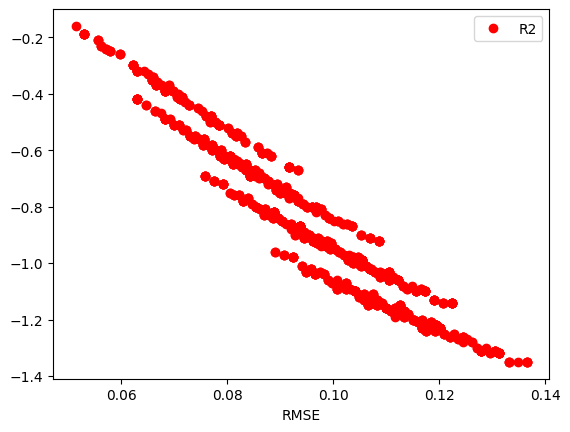

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Use 2017-2018 season snow depth to calibrate the model
snow_on = pd.Timestamp(2017,11,1)
snow_off = pd.Timestamp(2018,5,15)
Metrics = pd.DataFrame(columns = ['Parameters','RMSE','R2'])
# Locate to the file folder (Load snow depth data from HRDPS model)
os.chdir('../HRDPS') #../HRDPS
os.getcwd()

def read_snow_file(stn,year):
  SD = pd.read_csv('HRDPS_LW_snowdepth_'+stn+'_'+year+'.csv',sep = '\t',usecols = [0,1])
  SD.columns = ['DATE','SD']
  SD['SD'] = SD['SD']/100 # Convert unit to m
  SD['DATE'] = pd.to_datetime(SD['DATE'])
  return SD
# Load snow depth
year = '2017-2018' #input('Year? (eg. 2017-2018)')
SD = read_snow_file(stn,year)

for i in range(1000):
  p1 = random.sample([10,20,30], 1)
  p2 = random.sample([20,30,40,50], 1)
  while p2<p1:
    p2 = random.sample([20,30,40,50], 1)

  p3 = random.sample([50,60,70,80,90],1)
  while p3<p2:
    p3 = random.sample([50,60,70,80,90],1)

  p4 = random.sample([80,90,100,110,120],1)
  while p4<p3:
    p4 = random.sample([80,90,100,110,120],1)

  p5 = random.sample([100,110,120,130,140,150],1)
  while p5<p4:
    p5 = random.sample([100,110,120,130,140,150],1)

  parameters = list(p1+p2+p3+p4+p5)
  Meteo = SD_calculation(Meteo,snow_on,snow_off,parameters)
  Eval = Meteo.merge(SD, on = 'DATE',how = 'inner')[['DATE','SNOW','SD']]
  Eval.columns = ['DATE','PRED','TRUE']
  R2 = np.round(r2_score(Eval['PRED'],Eval['TRUE']),2)
  RMSE = mean_squared_error(Eval['PRED'],Eval['TRUE'],squared = False)
  df = pd.DataFrame({'Parameters':[parameters],'R2':R2,'RMSE':RMSE})
  Metrics = pd.concat([Metrics,df],axis=0)

Metrics.plot(x = 'RMSE',y = 'R2',style = 'ro')


In [8]:
## Choose the parameter set with best performance
parameters = list(Metrics[(Metrics['R2']>-0.2)&(Metrics['RMSE']<0.055)]['Parameters'])[0] # Thresholds are adjustable
print(parameters)

[20, 20, 50, 80, 150]


<Axes: xlabel='DATE'>

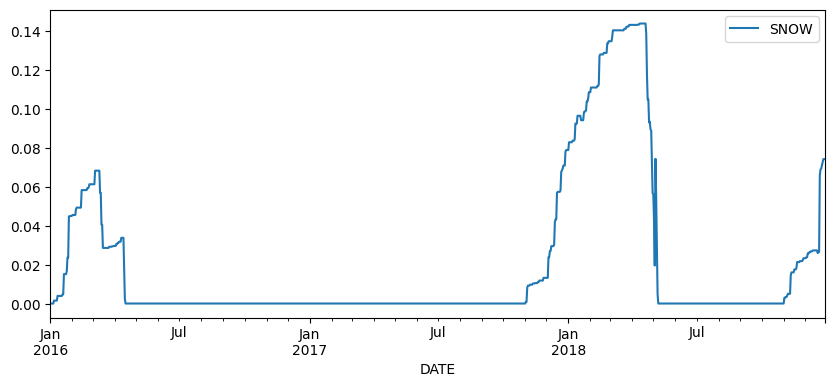

In [9]:
## 2015-2016 snow season
snow_on = pd.Timestamp(2015,1,1)
snow_off = pd.Timestamp(2016,5,15)
Meteo = SD_calculation(Meteo,snow_on,snow_off,parameters)

## 2016-2017 snow season
snow_on = pd.Timestamp(2016,11,1)
snow_off = pd.Timestamp(2017,5,15)
Meteo = SD_calculation(Meteo,snow_on,snow_off,parameters)

## 2017-2018 snow season
snow_on = pd.Timestamp(2017,11,1)
snow_off = pd.Timestamp(2018,5,15)
Meteo = SD_calculation(Meteo,snow_on,snow_off,parameters)

## 2018-2019 snow season
snow_on = pd.Timestamp(2018,11,1)
snow_off = pd.Timestamp(2019,5,15)
Meteo = SD_calculation(Meteo,snow_on,snow_off,parameters)
Meteo.plot(x = 'DATE',y = 'SNOW',figsize = (10,4))

## Model evaluation (calibrate against 2017-2018 season, validate against 2018-2019 season)

In [10]:
# Locate to the file folder (Load snow depth data from HRDPS model)
os.chdir('../HRDPS') #../HRDPS
os.getcwd()

def read_snow_file(stn,year):
  SD = pd.read_csv('HRDPS_LW_snowdepth_'+stn+'_'+year+'.csv',sep = '\t',usecols = [0,1])
  SD.columns = ['DATE','SD']
  SD['SD'] = SD['SD']/100 # Convert unit to m
  SD['DATE'] = pd.to_datetime(SD['DATE'])
  return SD
# Load snow depth
year = '2017-2018' #input('Year? (eg. 2017-2018)')
SD_cal = read_snow_file(stn,year)

year = '2018-2019'
SD_val = read_snow_file(stn,year)

Calibration R2: -0.19
validation R2: 0.49


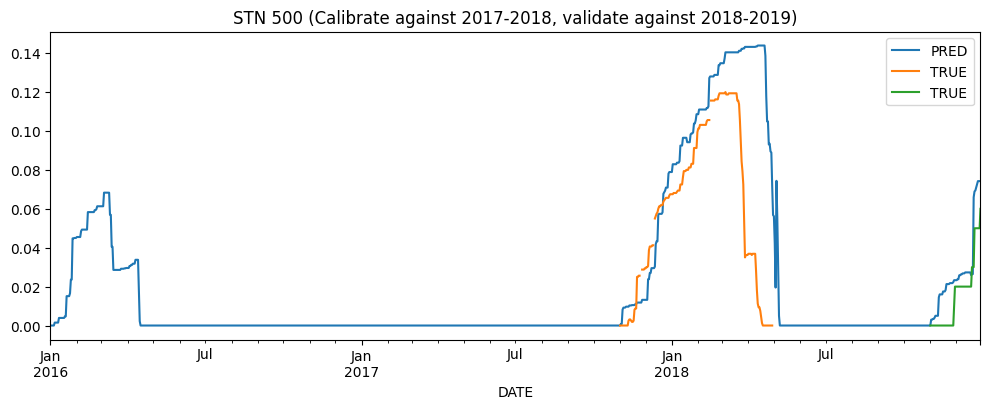

In [12]:

Eval = Meteo.merge(SD_cal, on = 'DATE',how = 'left')[['DATE','SNOW','SD']]
Eval.columns = ['DATE','PRED','TRUE']
f,ax = plt.subplots(figsize = (12,4))
Eval.plot(x = 'DATE',y = ['PRED','TRUE'],ax = ax)
print('Calibration R2: {}'.format(np.round(r2_score(Eval.dropna()['PRED'],Eval.dropna()['TRUE']),2)))

Eval = Meteo.merge(SD_val, on = 'DATE',how = 'left')[['DATE','SNOW','SD']]
Eval.columns = ['DATE','PRED','TRUE']
Eval.plot(x = 'DATE',y = ['TRUE'],ax = ax,label = '')
ax.set_title('STN '+stn+' (Calibrate against 2017-2018, validate against 2018-2019)')
print('validation R2: {}'.format(np.round(r2_score(Eval.dropna()['PRED'],Eval.dropna()['TRUE']),2)))
